In [1]:
cd ..

/Users/kimyoungh/GoogleDrive/rich/main/rich


In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp

In [3]:
returns = pd.read_csv('index_strategy_returns.csv', header=0,
                    index_col=0)
returns.index = returns.index.astype(str)

In [4]:
returns['K200_2X'] = returns['K200'] * 2
returns['KQ_2X'] = returns['KQ'] * 2

In [5]:
rs = []
for i in range(len(returns) - 20):
    r = returns.values[i+1:i+20+1]
    rs.append(r)

rs = np.stack(rs, axis=0)

In [6]:
rs.shape

(4978, 20, 6)

In [7]:
returns.values[:20]

array([[-0.00716926, -0.00373497,  0.00716926,  0.00373497, -0.01433851,
        -0.00746995],
       [ 0.01229836,  0.0134685 , -0.01229836, -0.0134685 ,  0.02459673,
         0.026937  ],
       [ 0.0102541 ,  0.01287843, -0.0102541 , -0.01287843,  0.02050821,
         0.02575685],
       [ 0.02493383,  0.01487894, -0.02493383, -0.01487894,  0.04986766,
         0.02975788],
       [ 0.02131319, -0.00026658, -0.02131319,  0.00026658,  0.04262639,
        -0.00053315],
       [ 0.0229764 ,  0.01946412, -0.0229764 , -0.01946412,  0.04595279,
         0.03892824],
       [ 0.00370905,  0.04603114, -0.00370905, -0.04603114,  0.0074181 ,
         0.09206228],
       [-0.00964889, -0.01125141,  0.00964889,  0.01125141, -0.01929778,
        -0.02250281],
       [-0.03254568, -0.03654068,  0.03254568,  0.03654068, -0.06509135,
        -0.07308136],
       [-0.00374972,  0.01522307,  0.00374972, -0.01522307, -0.00749943,
         0.03044613],
       [-0.00569952, -0.01783866,  0.00569952,  0.

In [8]:
def max_sr(returns):
    """
        Maximize Sharpe Ratio

        Args:
            returns: pd.DataFrame or np.array
        Return:
            weights: np.array(N) 
    """
    if isinstance(returns, pd.DataFrame):
        returns = returns.values

    creturns = returns
    cov = np.cov(creturns.transpose())
    cov = np.nan_to_num(cov)

    mu = creturns.mean(0).reshape(-1)

    weights = cp.Variable(returns.shape[1])

    objective = cp.Maximize(mu.T @ weights)

    constraints = [cp.sum_squares(cov @ weights) <= 1] 

    prob = cp.Problem(objective, constraints)

    prob.solve()

    weights = weights.value
    weights[weights < 0] = 0.
    weights = weights / weights.sum()

    return weights

In [9]:
returns.shape

(4998, 6)

In [10]:
weights = []
window = 20
length = len(returns) - window
for i in range(length):
    rets = returns.iloc[i+1:i+window+1]
    w = max_sr(rets)

    weights.append(w)

weights = np.stack(weights, axis=0)
weights = pd.DataFrame(weights, index=returns.index[:length],
                        columns=returns.columns)

<AxesSubplot:>

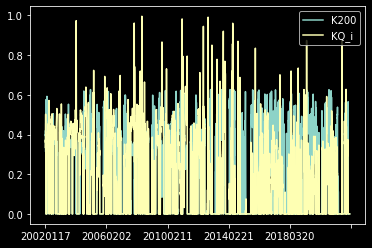

In [11]:
weights[['K200', 'KQ_i']].plot()

<AxesSubplot:>

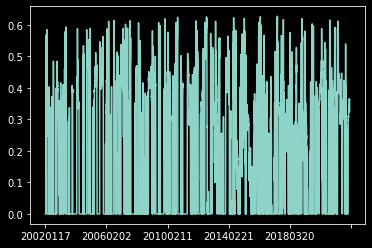

In [12]:
weights['KQ'].plot()

<AxesSubplot:>

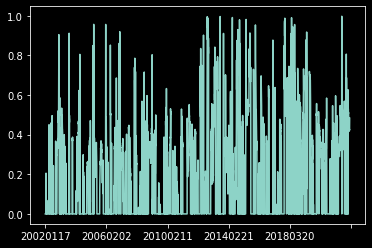

In [13]:
weights['K200_i'].plot()

In [15]:
weights

,K200,KQ,K200_i,KQ_i,K200_2X,KQ_2X
20020117,0.416885,0.000000,0.000000,0.335233,0.247882,0.000000
20020118,0.396509,0.000000,0.000000,0.367726,0.235765,0.000000
20020121,0.394952,0.000000,0.000000,0.370208,0.234840,0.000000
20020122,0.392931,0.000000,0.000000,0.373431,0.233638,0.000000
20020123,0.401768,0.000000,0.000000,0.359340,0.238893,0.000000
...,...,...,...,...,...,...
20220303,0.000000,0.359690,0.426437,0.000000,0.000000,0.213873
20220304,0.000000,0.359504,0.426734,0.000000,0.000000,0.213762
20220307,0.000000,0.362191,0.422448,0.000000,0.000000,0.215360
20220308,0.000000,0.326907,0.478713,0.000000,0.000000,0.194380


In [59]:
p = 4960
window = 20
rr = returns.iloc[p + 1:p + window + 1]
port = (((1 + rr).cumprod() - 1) * weights.iloc[p]).sum(axis=1)
rs = ((1 + rr).cumprod() - 1)
port = pd.concat((port ,rs), axis=1)

<AxesSubplot:>

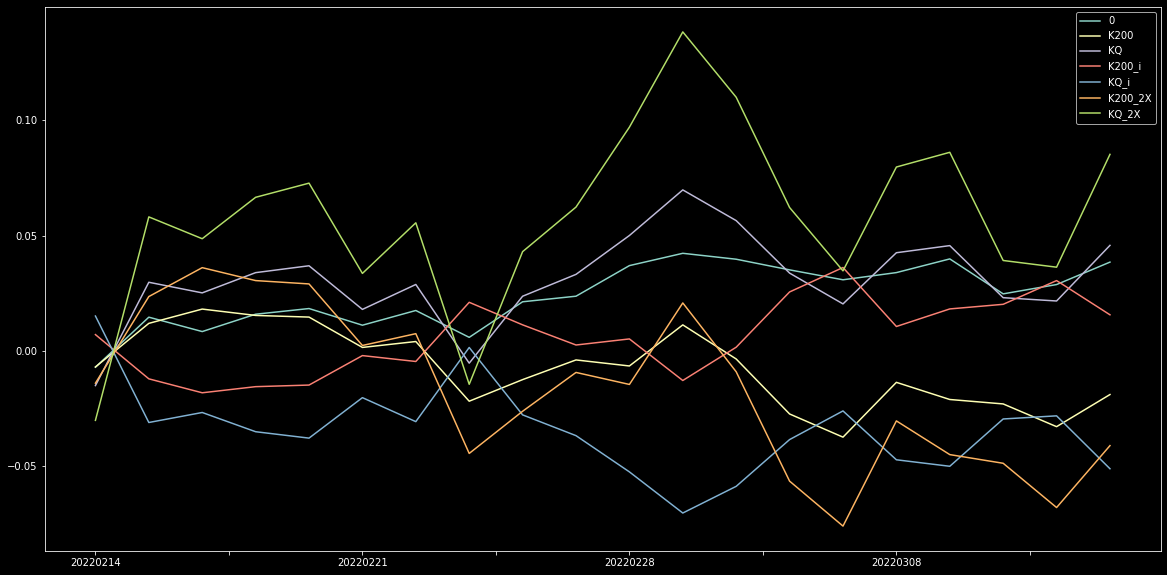

In [60]:
port.plot(figsize=(20, 10))

In [61]:
port

,0,K200,KQ,K200_i,KQ_i,K200_2X,KQ_2X
20220214,-0.007119,-0.007025,-0.015092,0.007025,0.015092,-0.014050,-0.030183
20220215,0.014587,0.011901,0.029738,-0.012169,-0.031112,0.023535,0.058102
20220216,0.008347,0.018100,0.025129,-0.018220,-0.026775,0.036075,0.048631
20220217,0.015873,0.015345,0.033912,-0.015564,-0.035114,0.030468,0.066600
20220218,0.018333,0.014629,0.036891,-0.014869,-0.037893,0.029014,0.072745
20220221,0.011106,0.001460,0.017965,-0.002083,-0.020332,0.002303,0.033584
20220222,0.017485,0.004022,0.028776,-0.004636,-0.030737,0.007431,0.055539
20220223,0.005833,-0.021874,-0.005371,0.021037,0.001434,-0.044538,-0.014531
20220224,0.021267,-0.012508,0.023675,0.011259,-0.027810,-0.026238,0.043025
20220225,0.023687,-0.003967,0.033162,0.002513,-0.036820,-0.009395,0.062357


In [62]:
weights.iloc[-1]

K200       0.000000
KQ         0.324136
K200_i     0.483131
KQ_i       0.000000
K200_2X    0.000000
KQ_2X      0.192733
Name: 20220310, dtype: float64

In [63]:
returns.iloc[4001:4061].var() * 250

K200       0.020101
KQ         0.049913
K200_i     0.020101
KQ_i       0.049913
K200_2X    0.080402
KQ_2X      0.199652
dtype: float64

In [64]:
returns.var().argmin()

0

In [65]:
weights.describe()

,K200,KQ,K200_i,KQ_i,K200_2X,KQ_2X
count,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000
mean,0.216063,0.186146,0.183194,0.175443,0.128472,0.110683
std,0.210826,0.204609,0.238098,0.202915,0.125358,0.121661
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.279505,0.014477,0.000000,0.000000,0.166195,0.008608
75%,0.402297,0.387567,0.362112,0.365182,0.239207,0.230449
max,0.626471,0.627056,0.997183,0.995674,0.372502,0.372850
